# 자전거 대여 데이터

- 2011년부터 2022년까지 2년간의 자전거 대여 데이터 
- 캐피털 바이크셰어 회사가 공개한 운행 기록에 다양한 외부 소스에서 얻은 당시 날씨 정보를 조합 
- 한 시간 간격으로 기록됨
- 훈련 데이터 : 매달 1일부터 19일까지의 기록
- 테스트 데이터 : 매달 20일부터 월말까지의 기록 
- 피처
    - datetime : 기록 일시(1시간 간격)
    - season : 계절 
        - 1 : 봄(1분기)
        - 2 : 여름(2분기)
        - 3: 가을(3분기)
        - 4 : 겨울(4분기) 
        - 공식 문서에는 계절로 설명하고 있지만 실제로는 분기로 나누어져 있음 
    - holiday : 공휴일 여부(0 : 공휴일 아님, 1 : 공휴일)
    - workingday : 근무일 여부(0 : 근무일 아님, 1 : 근무일)
        - 주말과 공휴일이 아니면 근무일이라고 간주 
    - weather : 날씨
        - 1 : 맑음
        - 2 : 옅은 안개, 약간 흐림
        - 3 : 약간의 눈, 약간의 비와 천둥 번개, 흐림  
        - 4 : 폭우와 천둥 번개, 눈과 짙은 안개 
    - temp : 실제 온도
    - atemp : 체감 온도
    - humidity : 상대 습도
    - windspeed : 풍속
    - casual : 등록되지 않은 사용자(비회원) 수
    - registered : 등록된 사용자(회원) 수
    - count : 자전거 대여 수량 
- 종속변수 : count 
- 평가지표 : RMSLE(Root Mean Squared Logarithmic Error) 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


# 머신러닝 import 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import font_manager, rc
import matplotlib
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family=font_name)


In [3]:
def rmsle(y_true, y_pred, convertExp = True):
    '''
    실제 타깃값과 예측값을 인수로 전달하면 RMSLE 수치를 반환하는 함수
    convertExp : 입력 데이터를 지수변환할지 정하는 파라미터
    타깃값으로 log(count)를 사용한 경우에는 지수변환을 해줘야 함
    '''
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))

    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))

    return output

In [4]:
train_data = pd.read_csv('./data/bike/train.csv')
train_data['data_set'] = 'train'
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,train


In [5]:
test_data = pd.read_csv('./data/bike/test.csv')
test_data['data_set'] = 'test'
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,data_set
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,test
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,test
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,test
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,test
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,test


- test 데이터에 중요한 컬럼 3개가 없으니 추가해야 될것같다.

In [6]:
test_df_copy = test_data.copy()

In [7]:
# 테스트 데이터에 중요한 컬럼들 채우기 
test_df_copy['registered'] = 0 
test_df_copy['casual'] = 0
test_df_copy['count'] = 0 

In [8]:
# 데이터 합치기
all_df = pd.concat([train_data, test_df_copy], ignore_index = True)
all_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,train


In [9]:
all_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'data_set'],
      dtype='object')

In [10]:
# 시간대 파상 독립변수 만들기 
dt = pd.DatetimeIndex(all_df['datetime'])

# 인덱스 맞추기
all_df.set_index(dt, inplace= True)

all_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,train


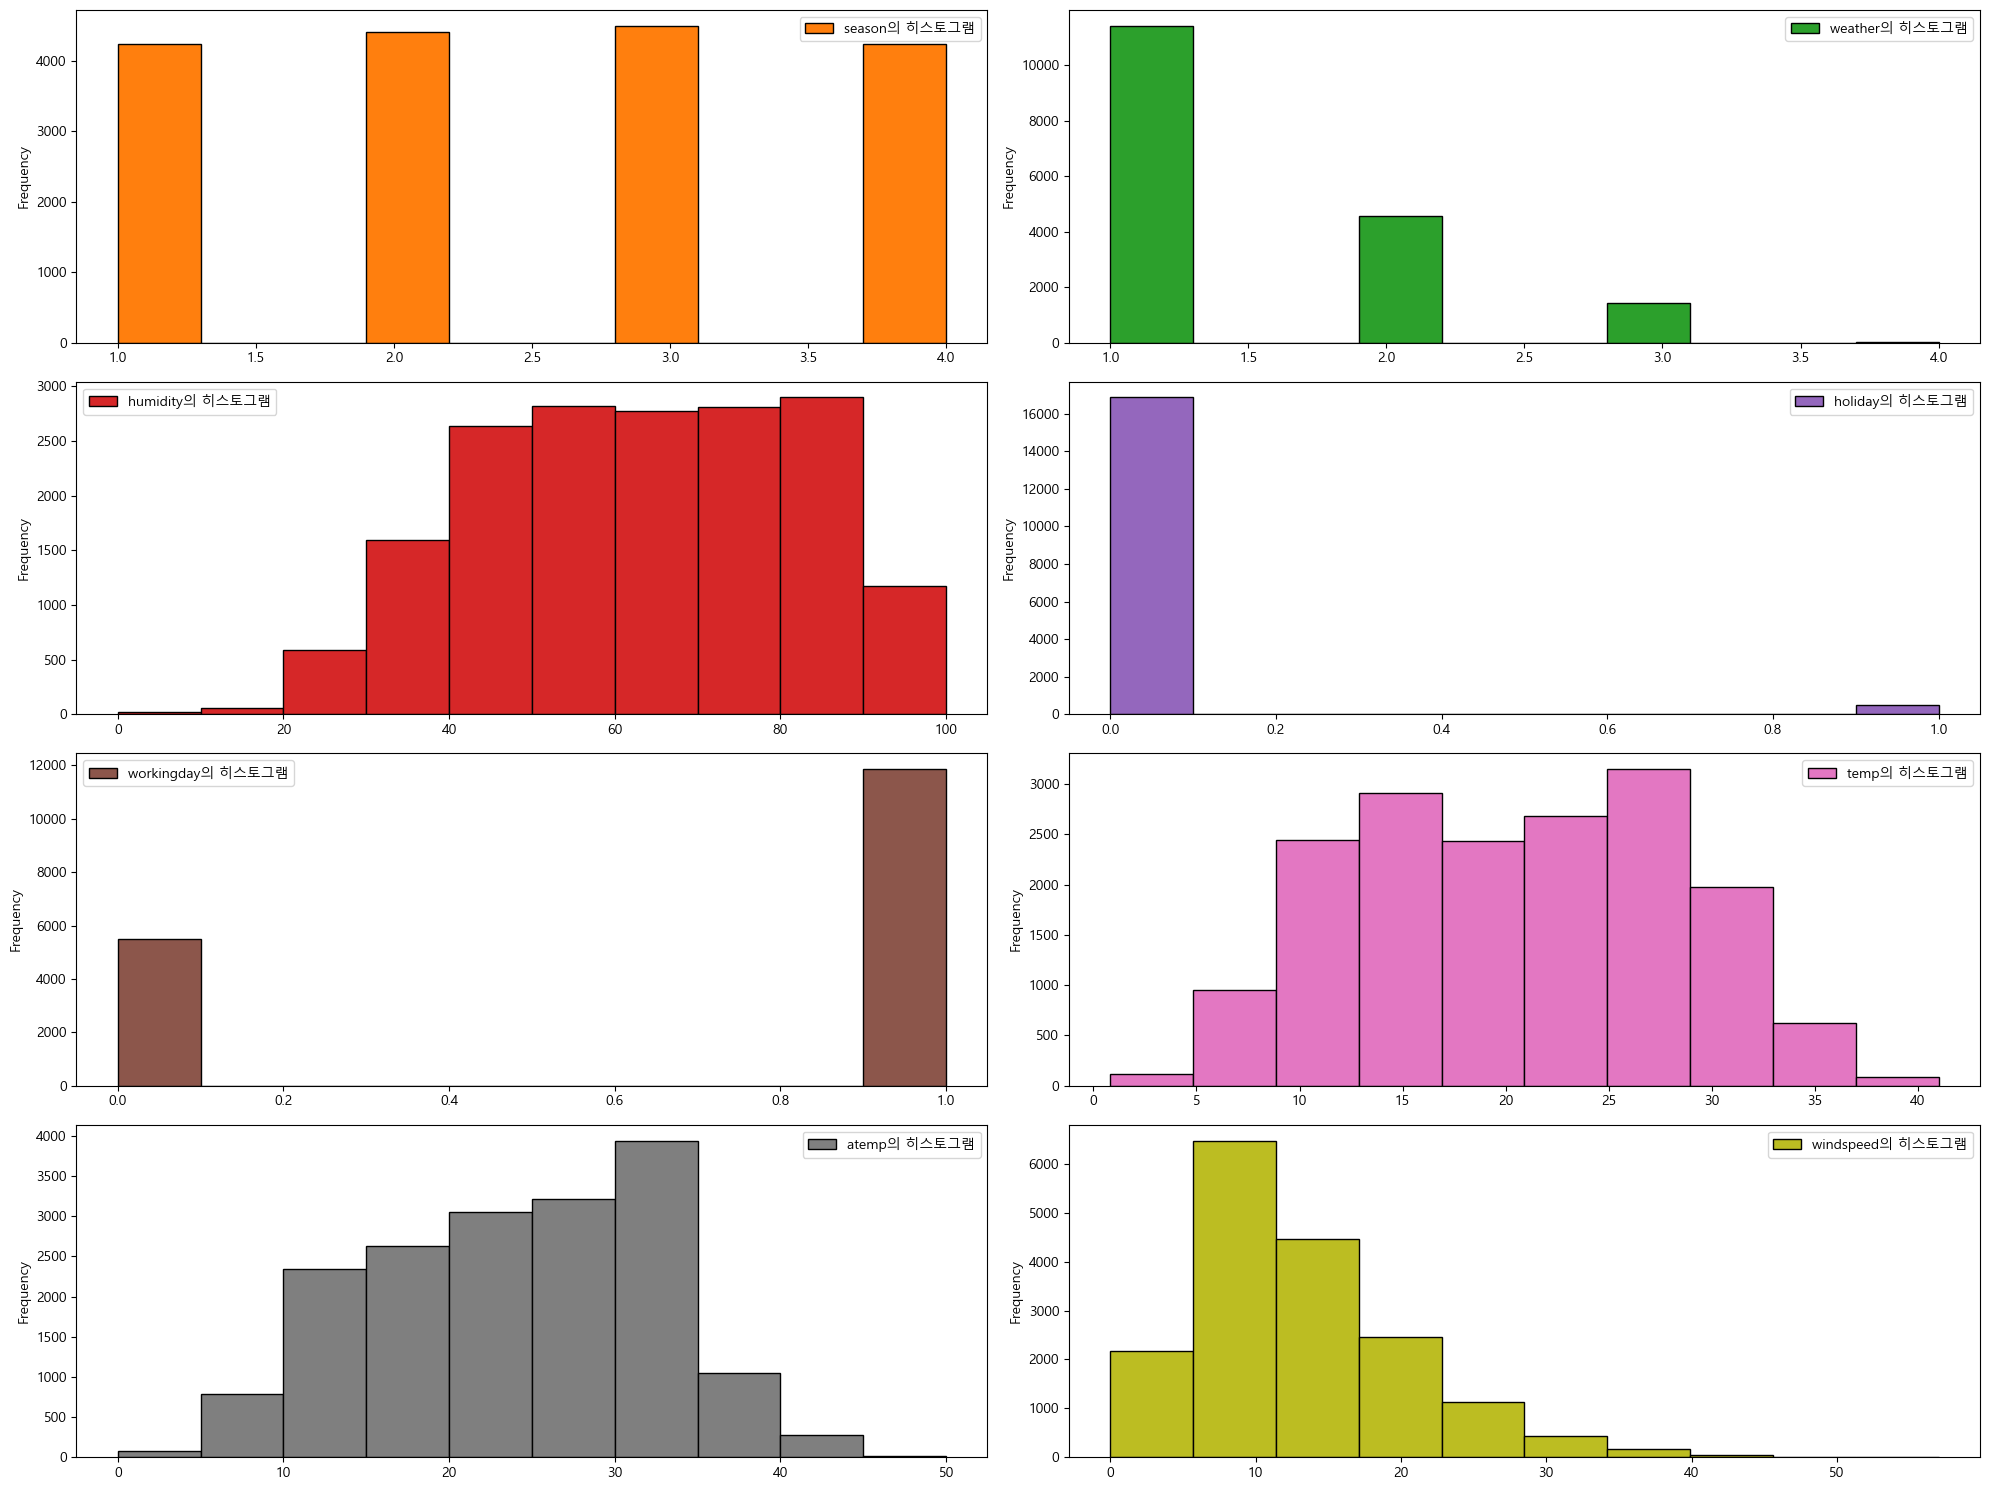

In [12]:
numeric_cols = ['season', 'weather', 'humidity', 'holiday', 'workingday', 'temp', 'atemp', 'windspeed']

# Define the figure size
plt.figure(figsize=(20, 15))

# Loop through the numeric columns and plot histograms
for i, col in enumerate(numeric_cols, start=1):
    plt.subplot(4, 2, i)
    all_df[col].plot.hist(bins=10, color='C'+str(i), label=f'{col}의 히스토그램', edgecolor='black')
    plt.legend(loc='best')

# Adjust the layout
plt.tight_layout()

In [13]:
train_1 = train_data.drop(['season', 'holiday', 'workingday','casual','registered'], axis =1)
train_1_corr = train_1.corr(numeric_only=True)
train_1_corr

,weather,temp,atemp,humidity,windspeed,count
weather,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


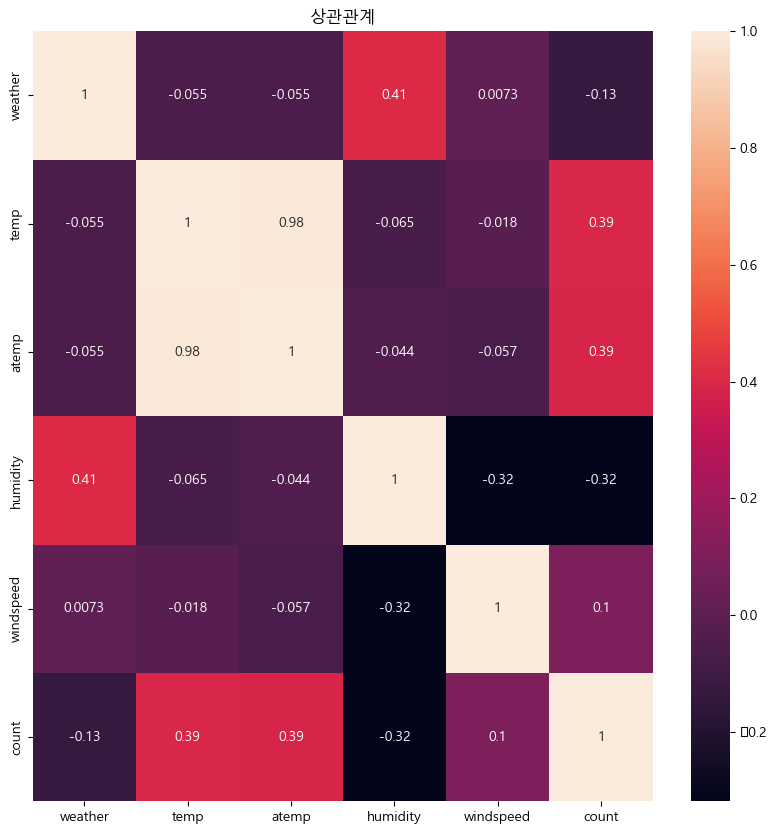

In [15]:
corrMat = train_1_corr
fig, ax= plt.subplots() 
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True) # 상관관계 히트맵 그리기
ax.set(title='상관관계');

In [17]:
train2 = train_data.copy()
train2

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,train
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,train
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,train
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,train
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,train
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,train
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,train
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,train


## 막대그래프

In [19]:
# 빌린 대여시간을 정확하게 보기 위해서는 시각화가 필요해 보인다 
all_df['date'] = all_df['datetime'].apply(lambda x: x.split()[0]) # 날짜 독립변수를 생성

# 연도, 월, 일, 시간 독립변수를 차례로 생성
all_df['year'] = all_df['datetime'].apply(lambda x: x.split()[0].split('-')[0]) 
all_df['month'] = all_df['datetime'].apply(lambda x: x.split()[0].split('-')[1])
all_df['day'] = all_df['datetime'].apply(lambda x: x.split()[0].split('-')[2]) 
all_df['hour'] = all_df['datetime'].apply(lambda x: x.split()[1].split(':')[0])

[Text(0.5, 1.0, '시간')]

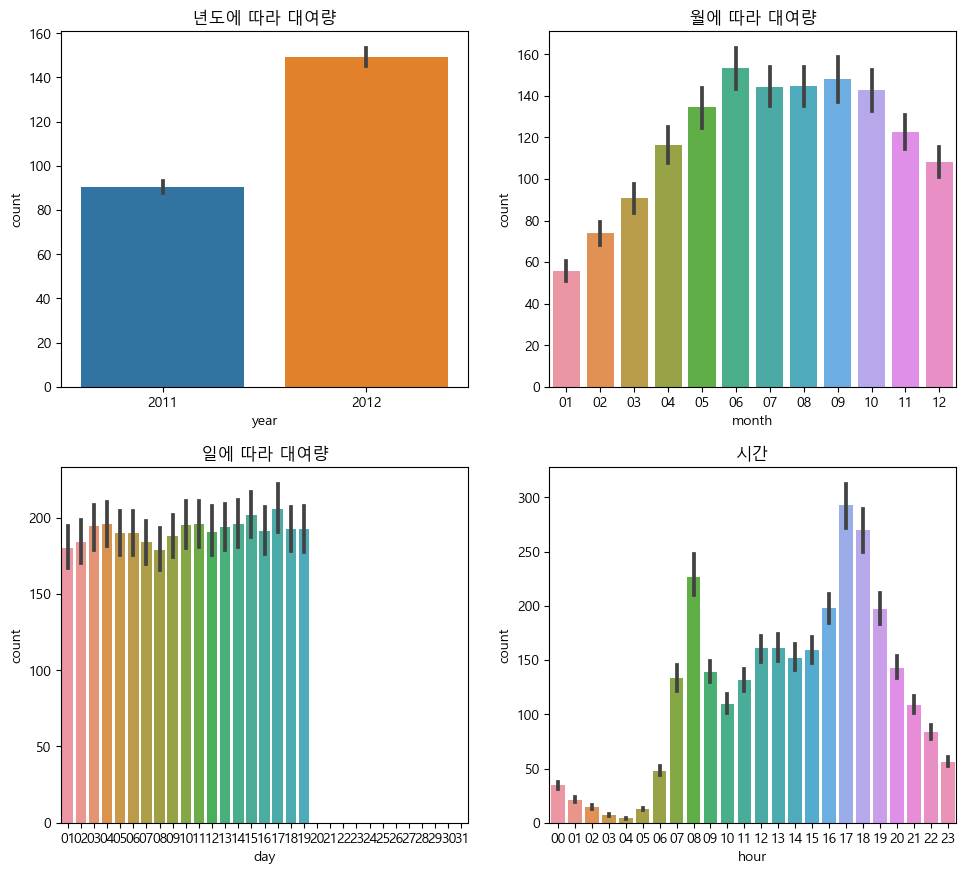

In [21]:
figure, axes = plt.subplots(nrows=2, ncols=2) 
plt.tight_layout()            
figure.set_size_inches(10, 9) 

# 각 축에 연도, 월, 일, 시간평균 대여 수량 막대 그래프 할당
sns.barplot(x='year', y='count', data=all_df, ax=axes[0, 0])
sns.barplot(x='month', y='count', data=all_df, ax=axes[0, 1])
sns.barplot(x='day', y='count', data=all_df, ax=axes[1, 0])
sns.barplot(x='hour', y='count', data=all_df, ax=axes[1, 1])

axes[0, 0].set(title='년도에 따라 대여량')
axes[0, 1].set(title='월에 따라 대여량')
axes[1, 0].set(title='일에 따라 대여량')
axes[1, 1].set(title='시간')

1. 년도 : 2012년이 현저히 대여량이 많다
2. 월 : 3분기가 제일 대여량이 많다
3. 일 : 일수는 평균적으로 비슷비슷하다. 또한 test 데이터에 20일 부터의 데이터가 있어서 공통된 값이 없으므로 day 독립변수를 지워도 될것같다. 
4. 시간 : 출근시간인 아침 8 시, 오후 5시 6시가 대여량이 높다

## 포인트 플롯

<Axes: xlabel='hour', ylabel='count'>

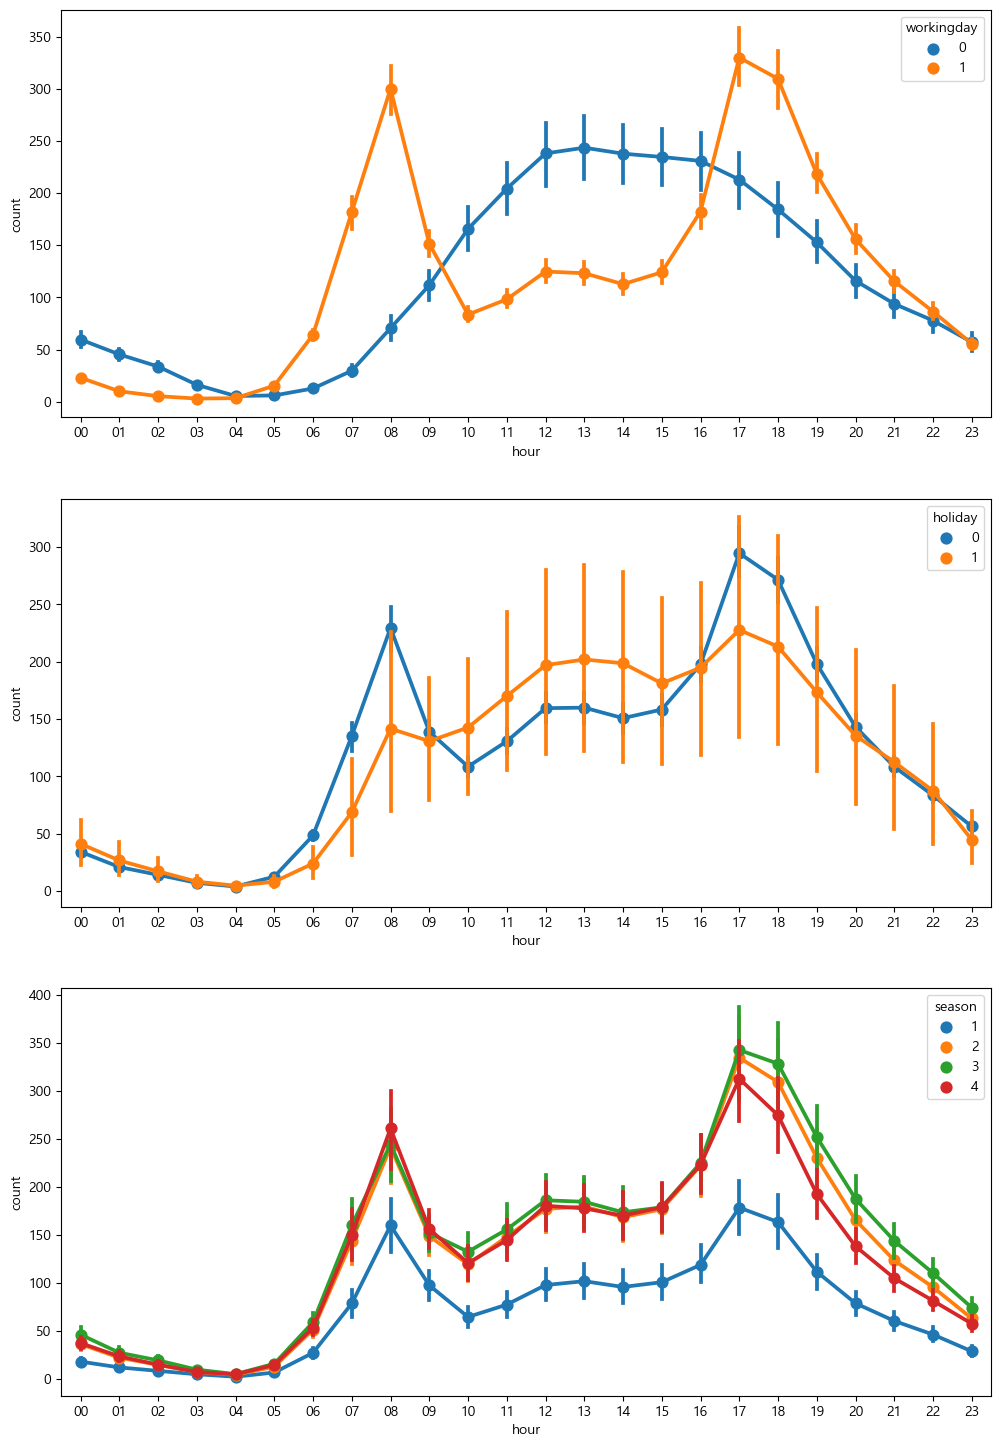

In [22]:
figure, axes = plt.subplots(nrows=3) 
figure.set_size_inches(12, 18)

# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트플롯
sns.pointplot(x='hour', y='count', data=all_df, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=all_df, hue='holiday', ax=axes[1])
# sns.pointplot(x='hour', y='count', data=train_nf, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='count', data=all_df, hue='season', ax=axes[2])

In [23]:
all_df = all_df[all_df['weather'] != 4]

In [24]:
all_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'data_set', 'date', 'year', 'month', 'day', 'hour'],
      dtype='object')

## 머신러닝 데이터분할

In [26]:
x = all_df[['season', 'holiday', 'workingday', 'weather', 
                  'temp', 'atemp', 'humidity', 'year', 'month', 'day']]

y = all_df['count']

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=11)

In [29]:
x_train.shape, x_test.shape

((12163, 10), (5213, 10))